# Conway's Game of Life Project

This notebook is an adaptation of a take-home coding project I did whilst applying for an internship. The position was filled shortly after I applied, so this project was never used. I have converted it to a notebook format for practice and portfolio purposes. This notebook will consist of code to generate a Conway's Game of Life scenario. Following will be a simple Keras model that will learn to predict 1 step of the game.

### SECTION 1: CGOL Code
The game begins with a populated 2D grid of 0s and 1s. Cells with 0 are dead, and cells with 1 are alive.


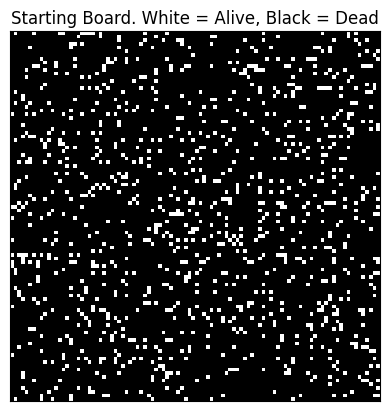

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# for display purposes
def render_frames(frames, nframes, titles, shape, fixMarg=None): # len(frames) must == len(titles)
  for i in range(nframes):
    plt.subplot(1, nframes, i + 1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(frames[i].flatten().reshape(shape), cmap='gray')
  if (fixMarg):
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9)

# create starter board
shape = (100, 100)
nums = np.random.choice([0, 1], size=shape, p=[.9, .1])
render_frames([nums], 1, ['Starting Board. White = Alive, Black = Dead'], shape)
plt.show()

The game proceeds stepwise via a set of rules.
The following explanation of the rules is from <a href="https://www.nytimes.com/2020/12/28/science/math-conway-game-of-life.html#:~:text=Birth%20rule%3A%20An%20empty%2C%20or,or%20three%20neighbors%20remains%20alive">The New York Times</a>.

>"The game was simple: Place any configuration of cells on a grid, then watch what transpires according to three rules that dictate how the system plays out:<br><br>Birth rule: An empty, or “dead,” cell with precisely three “live” neighbors (full cells) becomes live.<br><br>Death rule: A live cell with zero or one neighbors dies of isolation; a live cell with four or more neighbors dies of overcrowding.<br><br>Survival rule: A live cell with two or three neighbors remains alive."

In [23]:
"""
  Study Citation: https://www.youtube.com/watch?v=fei4bJQdBUQ

  This algorithm initially goes through the grid and assigns each value
  based upon a truth table.This is essential, as cells that are going to be
  birthed (0 -> 1) next round count as living neighbors.

  Truth Table
  Original | New | State
      0    |  0  |   0
      1    |  0  |   1   <--- Death Rule
      0    |  1  |   2   <--- Birth Rule
      1    |  1  |   3   <--- Survival Rule
"""
def countNeighbors(i, j, m, n, grid):
  nei = 0
  for x in [-1, 0, 1]:
    for y in [-1, 0, 1]:
      row = i + x
      col = j + y
      if ((row >= 0 and col >= 0) and
          (row < m and col < n) and
          (i != row or j != col) and
          (grid[row][col] == 1 or grid[row][col] == 3)):
          nei += 1
  return nei

def Iterate(grid, iterations, m ,n):
    if (iterations <= 0): # error prevention
        return
    # adjust grid based on truth table
    for i in range(m): # iterate thru given grid
        for j in range(n):
            livingNeighbors = countNeighbors(i, j, m, n, grid)
            if grid[i][j] == 1: ## if zero
                if livingNeighbors == 3 or livingNeighbors == 2:
                    grid[i][j] = 3 # surival rule, stays 1 if death rule
            elif livingNeighbors == 3:
                    grid[i][j] = 2 # birth rule
    for i in range(m): # iterate thru given grid
        for j in range(n):
          if grid[i][j] == 1:
            grid[i][j] = 0 # flip death rule cell to 0
          elif (grid[i][j] == 2 or grid[i][j] == 3):
            grid[i][j] = 1 # flip birth or survival cells to 1
    iterations -= 1
    if iterations > 0 :
        return Iterate(grid, iterations, m, n)
    return

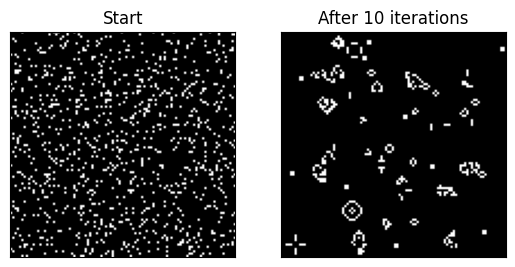

In [14]:
# create starter board
shape = (100, 100)
nums = np.random.choice([0, 1], size=shape, p=[.9, .1])
res = nums.copy()
Iterate(res, 10, shape[0], shape[1]) # pass grid by ref
render_frames([nums, res], 2, ['Start', 'After 10 iterations'], shape)
plt.show()

### SECTION 2: CGOL CNN

The model is a simple convolutional neural network with no pooling layer. Since the data being handled
is quite simple, I wanted to go for a minimum possible approach in terms of the size of the data and the
amount of layers. I only used one Conv2D layer with a filter size of 50, and a kernel shape of (3,3). I
use a SpacialDropout2D layer to make the model more robust as well. The Dense layer with 50 units was the smallest
amount I could achieve a strong accuracy with.

I generated a set of 50,000 pairs of game boards. 35000 were allocated to training data, 10000 were allocated to
testing data, and 5000 were allocated for validation. The boards were size (20,20). I only did 1 step of generation to save time on data generation. The amount of recursive calls takes a while on Colab. No major tweaks
were made to the data other than some reshaping. The boards could have been padded to account for the Conv2D layer
making possible errors at the edges, but because the model was already displaying high accuracy.

Citations:
- https://keras.io/
- https://kylewbanks.com/blog/conways-game-of-life-convolutional-neural-network-keras
- https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
- https://ieeexplore.ieee.org/abstract/document/8078730

Note: This cell took ~11min to run on free Colab

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, SpatialDropout2D
import tensorflow as tf
import random

def makeBoard(numBoards, shape=(50,50), probLive = 0.2):
	return (np.array([np.random.choice([False,True], size = shape, p = [1 - probLive, probLive])
		for a in range(numBoards)]).astype(int))

def reshape(X):
	return X.reshape(X.shape[0], X.shape[1], X.shape[2],1)

def genSet(numBoards, shape):
  probLive = random.uniform(0.1, 0.3) # generate random probabilities for living cells
  X = makeBoard(numBoards, shape, probLive)
  X = reshape(X)
  y = X.copy()
  for i in y:
    Iterate(i, 1, shape[0], shape[1])
  # y = np.array([Iterate(i, 1) for i in X])
  return X, y

# create variables and data
train = 35000
test = 10000
validate = 5000
shape = (20,20)
X_train, y_train  = genSet(train, shape)
X_test, y_test = genSet(test, shape)
X_valid, y_valid = genSet(validate, shape)

In [17]:
# model definition and training
model = Sequential([
    Conv2D(50, (3,3), padding='same', activation='relu', strides=1, input_shape=(shape[0], shape[1], 1)),
    SpatialDropout2D(0.5),
    Dense(50, activation  = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
700/700 [==============================] - 23s 32ms/step - loss: 0.1850 - accuracy: 0.9149 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 2/5
700/700 [==============================] - 22s 31ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.2536e-04 - val_accuracy: 1.0000
Epoch 3/5
700/700 [==============================] - 21s 29ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 6.1732e-05 - val_accuracy: 1.0000
Epoch 4/5
700/700 [==============================] - 23s 34ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 2.2537e-05 - val_accuracy: 1.0000
Epoch 5/5
700/700 [==============================] - 22s 31ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.3672e-05 - val_accuracy: 1.0000


In [28]:
# Generating real Generation and model Prediction
test = np.array(np.random.choice([0, 1], size = shape, p = [0.8, 0.2]))
test_res = test.copy()
Iterate(test_res, 1, shape[0], shape[1])
test_ts = tf.convert_to_tensor(test)
test_ts = tf.reshape(test_ts, [1, 20, 20, 1])
prob_res = model.predict(test_ts)
res = np.zeros(shape=shape)
prob_res = tf.reshape(prob_res, [20, 20])
for i in range(20):
  for j in range(20):
    if prob_res[i,j] > 0.5:
      res[i, j] = 1
    else:
      res[i, j] = 0

1/1 [==============================] - 0s 79ms/step


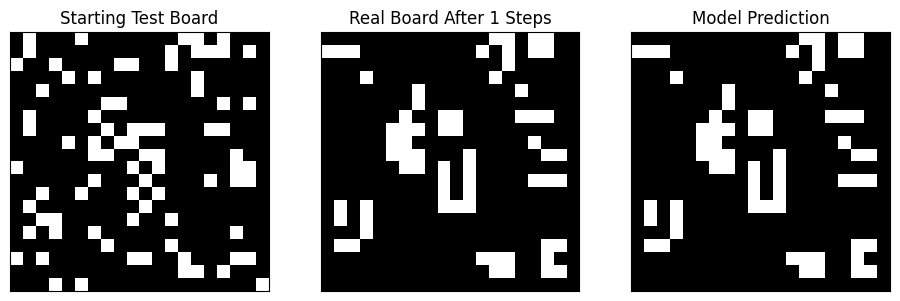

In [29]:
render_frames([test, test_res, res], 3, ["Starting Test Board", "Real Board After 1 Steps", "Model Prediction"], (20, 20), True)
plt.show()